# Deutsch's algorithm

In [1]:
from qiskit import __version__
print(__version__)

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

2.1.0


#### Define deutsch's algorithm
![deutsch](../Images/02.deutsch's-algo.png)

In [2]:
def deutsch_function(case: int):
    # This function generates a quantum circuit for one of the 4 functions
    # from one bit to one bit

    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

Next we will create the actual quantum circuit for Deutsch's algorithm, substituting the query gate with a quantum circuit implementation given as an argument. Shortly we'll plug in one of the four circuits defined by the function we defined earlier.

In [3]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in Deutsch's algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

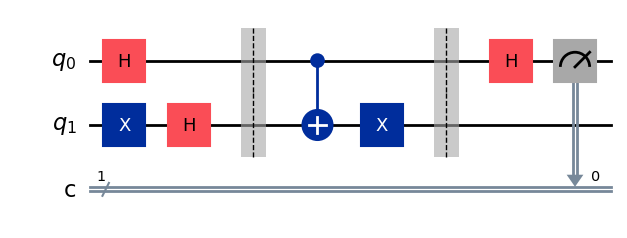

In [4]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

In [5]:
def deutsch_algorithm(function: QuantumCircuit):
    # Determine if a one-bit function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if measurements[0] == "0":
        return "constant"
    return "balanced"

f = deutsch_function(1)
display(deutsch_algorithm(f))

'constant'

# Deutsch-Jozsa problem

In [6]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

In [7]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
    print(on_states)

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        """
        Explain for this step
        For example: state = 6 = 110 -> q0 = 0; q1 = q2 = 1;
        only input state 001 -> i0 = 1; i1 = i2 = 0;
        q1 = 1 -> flip i1 to 1
        q2 = 1 -> flip i2 to 1
        -> flip output qubit
        """
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits) # mcx only trigger when all controled bits is 1
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

[5 7 3 2]


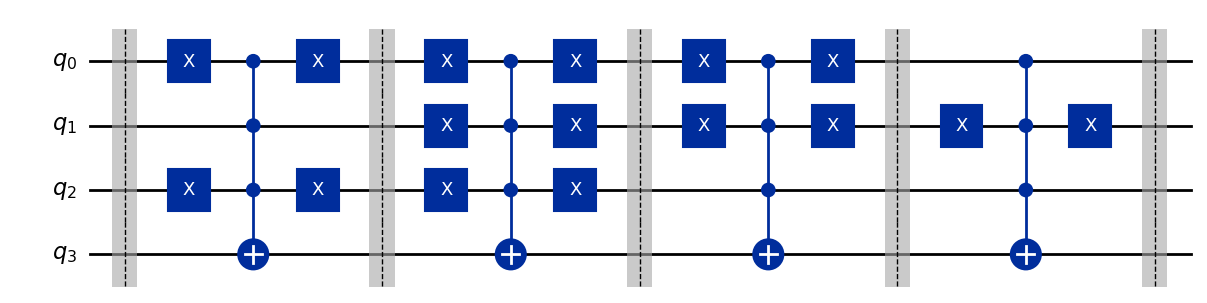

In [8]:
display(dj_query(3).draw(output="mpl"))

In [9]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

In [10]:
def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.

    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

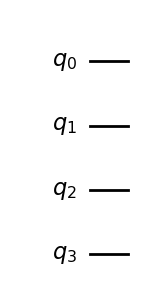

'constant'

In [11]:
f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))

## Binary Dot Product and Bernstein-Vazirani Problem

#### Notation

First let's introduce some notation. For any two binary strings $x = x_{n-1} \cdots x_0$ and $y = y_{n-1} \cdots y_0$ of length $n$, we define

$$x \cdot y = x_{n-1} y_{n-1} \oplus \cdots \oplus x_0 y_0$$

We'll refer to this operation as the **binary dot product**. 

An alternative way to define it is like so:

$$x \cdot y = \begin{cases}
1 & \text{if } x_{n-1} y_{n-1} + \cdots + x_0 y_0 \text{ is odd} \\
0 & \text{if } x_{n-1} y_{n-1} + \cdots + x_0 y_0 \text{ is even}
\end{cases}$$

Notice that this is a symmetric operation, meaning that the result doesn't change if we swap $x$ and $y$, so we're free to do that whenever it's convenient. Sometimes it's useful to think about the binary dot product $x \cdot y$ as being the parity of the bits of $x$ in positions where the string $y$ has a $1$, or equivalently, the parity of the bits of $y$ in positions where the string $x$ has a $1$.

#### Bernstein-Vazirani Problem

With this notation in hand we can now define the Bernstein-Vazirani problem.

**Bernstein-Vazirani Problem**

- **Input:** a function $f: \{0,1\}^n \to \{0,1\}$
- **Promise:** there exists a binary string $s = s_{n-1} \cdots s_0$ for which $f(x) = s \cdot x$ for all $x \in \{0,1\}^n$
- **Output:** the string $s$

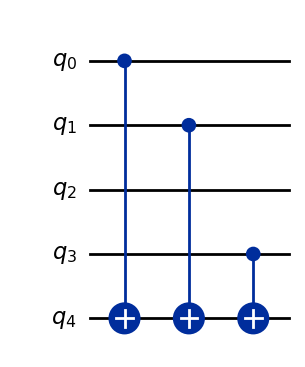

In [12]:
def bv_query(s):
    """f(x) = s.x"""
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_query("1011").draw(output="mpl"))

In [13]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

display(bv_algorithm(bv_query("1011")))

'1011'

## Simon's Problem

#### 1. Problem Definition

The input function for Simon's problem takes the form:

$$f: \Sigma^n \to \Sigma^m$$

for positive integers $n$ and $m$. We could restrict our attention to the case $m = n$ in the interest of simplicity, but there's little to be gained in making this assumption — Simon's algorithm and its analysis are basically the same either way.

**Simon's Problem**

**Input**: A function $f: \Sigma^n \to \Sigma^m$

**Promise**: There exists a string $s \in \Sigma^n$ such that:
$$[f(x) = f(y)] \Leftrightarrow [(x = y) \vee (x \oplus s = y)]$$
for all $x, y \in \Sigma^n$

**Output**: The string $s$

#### 2. Understanding the Promise

We'll unpack the promise to better understand what it says momentarily, but first let's be clear that it requires that $f$ has a very special structure — so most functions won't satisfy this promise. It's also fitting to acknowledge that this problem isn't intended to have practical importance. Rather, it's a somewhat artificial problem tailor-made to be easy for quantum computers and hard for classical computers.

There are two main cases: the first case is that $s$ is the all-zero string $0^n$, and the second case is that $s$ is not the all-zero string.

**Case 1: $s = 0^n$**

If $s$ is the all-zero string, then we can simplify the if and only if statement in the promise so that it reads:
$$[f(x) = f(y)] \Leftrightarrow [x = y]$$

This condition is true for all strings $x, y \in \Sigma^n$ if and only if $f$ is a **one-to-one function**.

Case 2: $s \neq 0^n$**

If $s$ is not the all-zero string, then the promise being satisfied for this string implies that $f$ is **two-to-one**, meaning that for every possible output string of $f$, there are exactly two input strings that cause $f$ to output that string. Moreover, these two input strings must take the form $x$ and $x \oplus s$ for some string $x$.

#### 3. Uniqueness of Solution

It's important to recognize that there can only be one string $s$ that works if the promise is met, so there's always a unique correct answer for functions that satisfy the promise.

#### 4. Example

Here's an example of a function taking the form $f: \Sigma^3 \to \Sigma^5$ that satisfies the promise for the string $s = 011$.

$$\begin{align}
f(000) &= 10011 \\
f(001) &= 00101 \\
f(010) &= 00101 \\
f(011) &= 10011 \\
f(100) &= 11010 \\
f(101) &= 00001 \\
f(110) &= 00001 \\
f(111) &= 11010
\end{align}$$

#### **Analysis of the Example**

There are 8 different input strings and 4 different output strings, each of which occurs twice — so this is a **two-to-one function**. Moreover, for any two different input strings that produce the same output string, we see that the bitwise XOR of these two input strings is equal to $011$, which is equivalent to saying that either one of them equals the other XORed with $s$.

#### **Verification**

Let's verify the promise condition for this example:

| Input Pair | Output | XOR of Inputs | Equals $s = 011$? |
|------------|--------|---------------|-------------------|
| $000, 011$ | $10011$ | $000 \oplus 011 = 011$ | ✓ |
| $001, 010$ | $00101$ | $001 \oplus 010 = 011$ | ✓ |
| $100, 111$ | $11010$ | $100 \oplus 111 = 011$ | ✓ |
| $101, 110$ | $00001$ | $101 \oplus 110 = 011$ | ✓ |

In [14]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1
    print(query_gate)

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

# Simon's Oracle Implementation: Complete Analysis

## Function Overview

```python
def simon_function(s: str):
    # Creates a quantum circuit implementing Simon's oracle
    # Input: s = hidden string (e.g., '101')
    # Output: QuantumCircuit satisfying Simon's promise
```

## Step-by-Step Breakdown

### 1. Circuit Setup
```python
n = len(s)
qc = QuantumCircuit(2 * n)
```

**Purpose**: Create quantum circuit with **2n qubits**
- **First n qubits**: Input register $|x\rangle$
- **Last n qubits**: Output register $|y\rangle$

**Example**: For `s = '101'` (n=3), we get 6 qubits total

### 2. Random Permutation Generation
```python
pi = np.random.permutation(2**n)
```

**Purpose**: Create a random shuffling of output values
- **Input**: Array $[0, 1, 2, \ldots, 2^n-1]$
- **Output**: Random permutation of these values
- **Effect**: Hides the structure from classical observation

**Example**: For n=3, might generate `π = [3,7,1,0,5,2,6,4]`

### 3. The Clever Function Construction

The algorithm constructs $f(x) = \pi(g(x))$ where:
$$g(x) = \min\{x, x \oplus s\}$$

#### Why This Works

**Mathematical Property**: For any inputs $a$ and $b$:
$$g(a) = g(b) \Leftrightarrow [a = b \text{ OR } a = b \oplus s]$$

**Proof**:
- If $a = b$: Obviously $g(a) = g(b)$ ✓
- If $a = b \oplus s$: Then $a \oplus s = b$, so $\{a, a \oplus s\} = \{a, b\} = \{b \oplus s, b\}$
  - Therefore $\min\{a, a \oplus s\} = \min\{b \oplus s, b\}$ ✓

#### Example with s = '11'

| x (binary) | x (decimal) | x ⊕ s | g(x) = min{x, x⊕s} |
|------------|-------------|-------|-------------------|
| 00 | 0 | 3 | 0 |
| 01 | 1 | 2 | 1 |
| 10 | 2 | 1 | 1 |
| 11 | 3 | 0 | 0 |

**Verification**:
- $g(00) = g(11) = 0$ ✓ (since $00 \oplus 11 = 11$)
- $g(01) = g(10) = 1$ ✓ (since $01 \oplus 11 = 10$)

### 4. Unitary Matrix Construction

```python
query_gate = np.zeros((4**n, 4**n))
for x in range(2**n):
    for y in range(2**n):
        z = y ^ pi[min(x, x ^ int(s, 2))]
        query_gate[x + 2**n * z, x + 2**n * y] = 1
```

#### Matrix Dimensions
- **Size**: $(4^n) \times (4^n) = (2^{2n}) \times (2^{2n})$
- **Basis states**: $|xy\rangle$ where $x,y \in \{0,1\}^n$
- **Indexing**: State $|x\rangle|y\rangle$ maps to index $x + 2^n \cdot y$

#### Transformation Logic
For each basis state $|x\rangle|y\rangle$:

1. **Compute** $g(x) = \min\{x, x \oplus s\}$
2. **Apply permutation** $\pi[g(x)]$
3. **Calculate output** $z = y \oplus \pi[g(x)]$
4. **Set matrix element** `query_gate[x + 2^n * z, x + 2^n * y] = 1`

This implements: $U_f|x\rangle|y\rangle = |x\rangle|y \oplus f(x)\rangle$

Where $f(x) = \pi(g(x)) = \pi(\min\{x, x \oplus s\})$

### 5. Final Circuit Assembly
```python
qc.unitary(query_gate, range(2 * n))
return qc
```

**Purpose**: Convert the unitary matrix into a quantum gate and add it to the circuit.

In [15]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

In [16]:
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [17]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)
    print(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [18]:
display(simon_algorithm(simon_function("10011")))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['11001', '01100', '01111', '01000', '10110', '01011', '11101', '11010', '10010', '11101', '00011', '01100', '11101', '01000', '10010']


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Guess for hidden string s: 


'10011'

## QPE

#### 1 bit precision

In [19]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
from math import pi

In [20]:
def qpe_1bit_function(theta):
   """Create a 1-bit QPE oracle function"""
   qc = QuantumCircuit(2)
   # Controlled phase gate: if control=1, apply phase e^(2πiθ) to target
   qc.cp(2 * pi * theta, 0, 1)
   return qc

def qpe_1bit_compile_circuit(function: QuantumCircuit):
   """Compile circuit for 1-bit quantum phase estimation"""
   qc = QuantumCircuit(2, 1)
   
   # Prepare eigenstate |1⟩ on target qubit
   qc.x(1)
   
   # Hadamard on control qubit
   qc.h(0)
   
   qc.barrier()
   qc.compose(function, inplace=True)
   qc.barrier()
   
   # Hadamard on control qubit
   qc.h(0)
   
   # Measure control qubit
   qc.measure(0, 0)
   
   return qc

def qpe_1bit_algorithm(function: QuantumCircuit):
    """Determine the phase θ with 1-bit precision"""
    qc = qpe_1bit_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000, memory=True).result()
    measurements = result.get_memory()
    
    count_0 = measurements.count('0')
    count_1 = measurements.count('1')
    
    print(f"Measured '0': {count_0} times")
    print(f"Measured '1': {count_1} times")
    
    if count_0 > count_1:
        return "0.0"  # θ closer to 0 (or 1 due to periodicity)
    return "0.5"

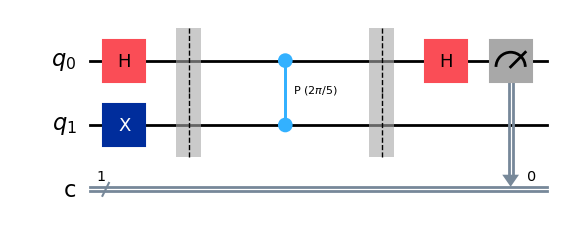

In [21]:
display(qpe_1bit_compile_circuit(qpe_1bit_function(0.2)).draw(output="mpl"))

In [22]:
display(qpe_1bit_algorithm(qpe_1bit_function(0.8)))

Measured '0': 652 times
Measured '1': 348 times


'0.0'

#### 2 bits precision

In [28]:
def qpe_2bit_function(theta):
    """Create a 2-bit QPE oracle function"""
    qc = QuantumCircuit(3)
    # Apply controlled-U^1 and controlled-U^2
    qc.cp(2 * pi * theta, 0, 2)        # U^1
    qc.cp(2 * pi * theta * 2, 1, 2)    # U^2
    return qc

def qpe_2bit_compile_circuit(function: QuantumCircuit):
    """Compile circuit for 2-bit quantum phase estimation"""
    qc = QuantumCircuit(3, 2)
    
    # Prepare eigenstate |1⟩ on target qubit
    qc.x(2)
    
    # Hadamard on control qubits
    qc.h([0, 1])
    
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
    
    # Inverse QFT on control qubits
    qc.h(1)
    qc.cp(-pi/2, 0, 1)
    qc.h(0)
    qc.swap(0, 1)
    
    # Measure control qubits
    qc.measure([0, 1], [0, 1])
    
    return qc

def qpe_2bit_algorithm(function: QuantumCircuit):
    """Determine the phase θ with 2-bit precision"""
    qc = qpe_2bit_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000).result()
    counts = result.get_counts()
    print(counts)
    
    # Find most frequent measurement
    best_result = max(counts.items(), key=lambda x: x[1])
    best_bitstring = best_result[0]
    
    # Convert binary to decimal phase
    phase_estimate = int(best_bitstring, 2) / 4
    return f"{phase_estimate:.3f}"

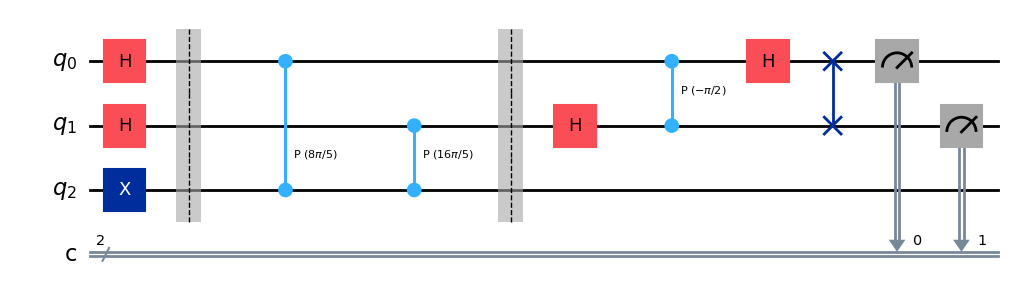

{'01': 26, '10': 26, '00': 55, '11': 893}


'0.750'

In [31]:
display(qpe_2bit_compile_circuit(qpe_2bit_function(0.8)).draw(output="mpl"))
display(qpe_2bit_algorithm(qpe_2bit_function(0.8)))

#### Quantum Fourier Transform (QFT)

The Quantum Fourier Transform is one of the most important quantum algorithms, forming the basis for many quantum algorithms including phase estimation and Shor's factoring algorithm.

**Mathematical Definition**

The QFT is defined using the primitive N-th root of unity:

$$\omega_N = e^{2\pi i/N} = \cos(2\pi/N) + i\sin(2\pi/N)$$

This represents a point on the unit circle at angle 2π/N radians.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from math import pi, cos, sin, sqrt

def omega_n(N):
    """Calculate the primitive N-th root of unity"""
    return np.exp(2j * pi / N)

def show_omega_examples():
    """Show examples of omega_N for different values of N"""
    print("Examples of ω_N:")
    
    examples = [1, 2, 3, 4, 8, 16, 100]
    for N in examples:
        w = omega_n(N)
        print(f"ω_{N} = {w:.3f}")
    
show_omega_examples()

Examples of ω_N:
ω_1 = 1.000-0.000j
ω_2 = -1.000+0.000j
ω_3 = -0.500+0.866j
ω_4 = 0.000+1.000j
ω_8 = 0.707+0.707j
ω_16 = 0.924+0.383j
ω_100 = 0.998+0.063j


In [33]:
def create_qft_matrix(N):
    """Create the N-dimensional QFT matrix"""
    omega = omega_n(N)
    matrix = np.zeros((N, N), dtype=complex)
    
    for x in range(N):
        for y in range(N):
            matrix[x, y] = (omega ** (x * y)) / sqrt(N)
    
    return matrix

def show_small_qft_matrices():
    """Display QFT matrices for small dimensions"""
    for N in [1, 2, 3, 4]:
        print(f"\nQFT_{N}:")
        qft_matrix = create_qft_matrix(N)
        
        # Round for cleaner display
        qft_rounded = np.round(qft_matrix, 3)
        print(qft_rounded)
        
        # Verify it's unitary
        should_be_identity = qft_matrix @ qft_matrix.conj().T
        is_unitary = np.allclose(should_be_identity, np.eye(N))
        print(f"Is unitary: {is_unitary}")

show_small_qft_matrices()


QFT_1:
[[1.+0.j]]
Is unitary: True

QFT_2:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]
Is unitary: True

QFT_3:
[[ 0.577+0.j   0.577+0.j   0.577+0.j ]
 [ 0.577+0.j  -0.289+0.5j -0.289-0.5j]
 [ 0.577+0.j  -0.289-0.5j -0.289+0.5j]]
Is unitary: True

QFT_4:
[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]
Is unitary: True


#### QFT Circuit Implementation

For N = 2^m, we can implement QFT efficiently with a quantum circuit using O(m²) gates.

In [ ]:
def qft_circuit(n_qubits):
    """Create QFT circuit for n qubits"""
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        # Apply Hadamard to qubit i
        qc.h(i)
        
        # Apply controlled rotations
        for j in range(i + 1, n_qubits):
            angle = pi / (2 ** (j - i))
            qc.cp(angle, j, i)
    
    # Reverse the order of qubits (swap)
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)
    
    return qc

def inverse_qft_circuit(n_qubits):
    """Create inverse QFT circuit for n qubits"""
    qc = QuantumCircuit(n_qubits)
    
    # Reverse the swaps first
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - 1 - i)
    
    # Apply inverse operations in reverse order
    for i in range(n_qubits - 1, -1, -1):
        # Apply controlled rotations with negative angles
        for j in range(n_qubits - 1, i, -1):
            angle = -pi / (2 ** (j - i))
            qc.cp(angle, j, i)
        
        # Apply Hadamard to qubit i
        qc.h(i)
    
    return qc

In [41]:
def create_qft_matrix(n_qubits):
    """Create manual QFT matrix for n qubits"""
    N = 2 ** n_qubits
    omega = np.exp(2j * pi / N)
    
    matrix = np.zeros((N, N), dtype=complex)
    for x in range(N):
        for y in range(N):
            matrix[x, y] = (omega ** (x * y)) / sqrt(N)
    
    return matrix

def qpe_manual_qft_function(theta, n_precision=3):
    """Create QPE oracle function"""
    qc = QuantumCircuit(n_precision + 1)
    
    # Apply controlled-U^(2^j) operations
    for j in range(n_precision):
        power = 2 ** j
        phase = 2 * pi * theta * power
        qc.cp(phase, j, n_precision)
    
    return qc

def qpe_manual_qft_compile_circuit(function: QuantumCircuit):
    """Compile QPE circuit using manual QFT matrix"""
    n_precision = function.num_qubits - 1
    n_total = function.num_qubits
    qc = QuantumCircuit(n_total, n_precision)
    
    # Prepare eigenstate |1⟩ on target qubit
    qc.x(n_precision)
    
    # Create superposition on precision qubits
    qc.h(range(n_precision))
    
    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()
    
    # Apply inverse QFT using manual matrix
    inverse_qft_matrix = create_qft_matrix(n_precision).conj().T
    qc.unitary(inverse_qft_matrix, range(n_precision), label='IQFT')
    
    # Measure precision qubits
    qc.measure(range(n_precision), range(n_precision))
    
    return qc

def qpe_manual_qft_algorithm(function: QuantumCircuit):
    """QPE algorithm using manual QFT matrix"""
    qc = qpe_manual_qft_compile_circuit(function)
    
    result = AerSimulator().run(qc, shots=1000).result()
    counts = result.get_counts()
    
    print("Measurement counts:")
    for bitstring, count in sorted(counts.items()):
        prob = count / 1000
        n_precision = len(bitstring)
        estimate = int(bitstring, 2) / (2 ** n_precision)
        print(f"  {bitstring}: {count:3d} ({prob:.3f}) → θ = {estimate:.3f}")
    
    # Find most frequent measurement
    best_result = max(counts.items(), key=lambda x: x[1])
    best_bitstring = best_result[0]
    
    n_precision = len(best_bitstring)
    phase_estimate = int(best_bitstring, 2) / (2 ** n_precision)
    
    return f"{phase_estimate:.3f}"

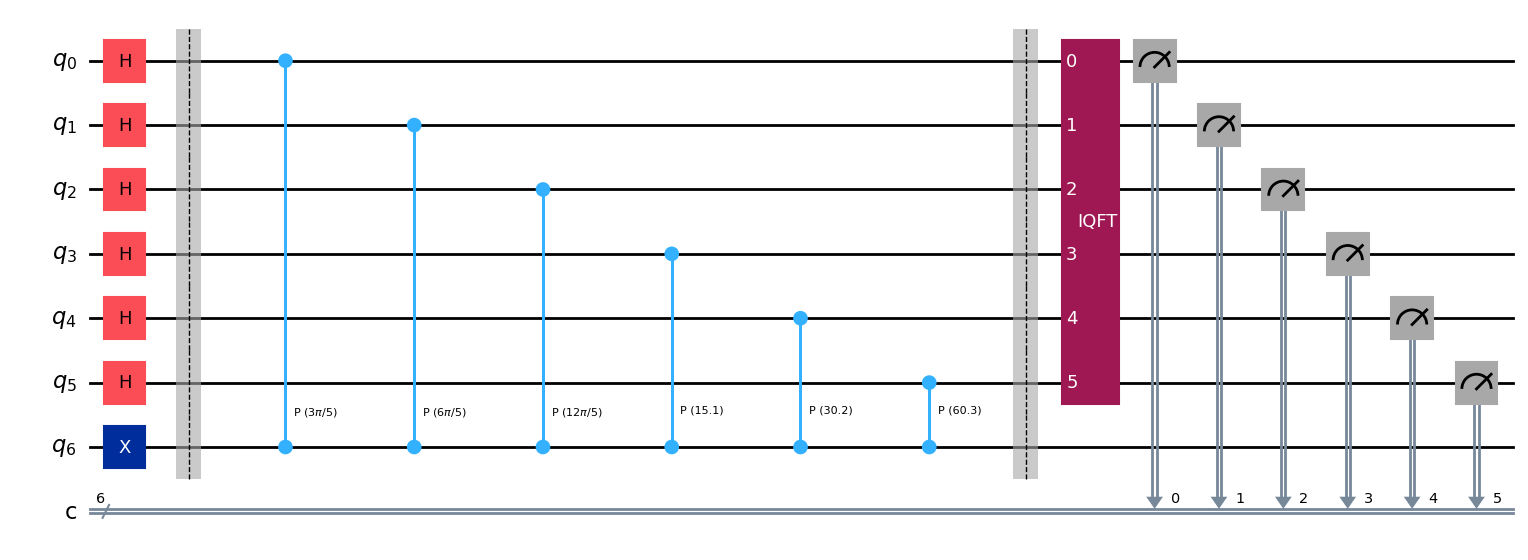

Measurement counts:
  000100:   1 (0.001) → θ = 0.062
  000111:   1 (0.001) → θ = 0.109
  001000:   1 (0.001) → θ = 0.125
  001010:   1 (0.001) → θ = 0.156
  001100:   2 (0.002) → θ = 0.188
  001101:   1 (0.001) → θ = 0.203
  001110:   1 (0.001) → θ = 0.219
  001111:   3 (0.003) → θ = 0.234
  010000:   3 (0.003) → θ = 0.250
  010001:   5 (0.005) → θ = 0.266
  010010:  24 (0.024) → θ = 0.281
  010011: 883 (0.883) → θ = 0.297
  010100:  50 (0.050) → θ = 0.312
  010101:   8 (0.008) → θ = 0.328
  010110:   7 (0.007) → θ = 0.344
  010111:   4 (0.004) → θ = 0.359
  011000:   3 (0.003) → θ = 0.375
  100010:   1 (0.001) → θ = 0.531
  101000:   1 (0.001) → θ = 0.625


'0.297'

In [44]:
theta = 0.3
display(qpe_manual_qft_compile_circuit(qpe_manual_qft_function(theta, n_precision=6)).draw(output="mpl"))
display(qpe_manual_qft_algorithm(qpe_manual_qft_function(theta, n_precision=6)))